In [ ]:
import json
import time
from openai import OpenAI
import re
from typing import List, Dict
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock

# Lock for thread-safe printing and progress updates
print_lock = Lock()
results_lock = Lock()

def create_client():
    return OpenAI(
        api_key="abcd",
        base_url="http://localhost:3060/auto/v1/",
        default_headers={
            "x-proxy-key": "3870443e-1f3e-4e5d-a1fe-4e945828cdc6"
        }
    )

def extract_answer(response: str) -> str:
    """Extract the final answer (A-F) from the model's response."""
    match = re.search(r"Final Answer:\s*([A-F])", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    match = re.search(r"([A-F])\s*$", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return "INVALID"

def evaluate_single_question(args):
    """Worker function for thread pool."""
    client, question, model, pbar, total_questions = args
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                # {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": question["prompt"]}
            ]
        )
        
        model_response = response.choices[0].message.content
        model_answer = extract_answer(model_response)
        correct = model_answer == question["answer"]
        
        result = {
            "question_id": question["question_id"],
            "correct_answer": question["answer"],
            "model_answer": model_answer,
            "correct": correct,
            "full_response": model_response,
            "prompt": question["prompt"]
        }
        
        # Thread-safe progress and result printing
        with print_lock:
            pbar.update(1)
            print(f"\nQuestion {question['question_id']}:")
            print("\nChain of Thought:")
            print("-" * 50)
            print(model_response)
            print("-" * 50)
            print(f"Expected: {question['answer']}")
            print(f"Got: {model_answer}")
            print(f"Correct: {'✓' if correct else '✗'}")
            print("=" * 80)
        
        return result
    
    except Exception as e:
        with print_lock:
            pbar.update(1)
            print(f"\nError processing question {question['question_id']}: {str(e)}")
        
        return {
            "question_id": question["question_id"],
            "correct_answer": question["answer"],
            "model_answer": "ERROR",
            "correct": False,
            "full_response": str(e),
            "prompt": question["prompt"]
        }

def save_results(results: List[Dict], model: str, output_dir: str = "evaluation_results"):
    """Save results in multiple formats with timestamps."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_path = Path(output_dir) / timestamp
    base_path.mkdir(parents=True, exist_ok=True)
    
    detailed_results = {
        "model": model,
        "timestamp": timestamp,
        "results": results
    }
    with open(base_path / "detailed_results.json", 'w') as f:
        json.dump(detailed_results, f, indent=2)
    
    df = pd.DataFrame(results)
    df.to_csv(base_path / "results.csv", index=False)
    
    cot_dir = base_path / "chain_of_thought"
    cot_dir.mkdir(exist_ok=True)
    
    for result in results:
        with open(cot_dir / f"question_{result['question_id']}.txt", 'w') as f:
            f.write(f"Question ID: {result['question_id']}\n")
            f.write(f"Prompt:\n{result['prompt']}\n\n")
            f.write(f"Model Response:\n{result['full_response']}\n\n")
            f.write(f"Expected Answer: {result['correct_answer']}\n")
            f.write(f"Model Answer: {result['model_answer']}\n")
            f.write(f"Correct: {result['correct']}\n")

def evaluate_model(json_file: str, model: str = "openai@gpt-4o", num_threads: int = 10) -> pd.DataFrame:
    """Evaluate the model on all questions in the JSON file using multiple threads."""
    # Load questions
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    questions = data["eval_data"]
    total_questions = len(questions)
    results = []
    
    # Create progress bar
    pbar = tqdm(total=total_questions, desc=f"Evaluating {model}")
    
    # Create a client for each thread
    clients = [create_client() for _ in range(num_threads)]
    
    # Prepare arguments for thread pool
    thread_args = [
        (clients[i % num_threads], question, model, pbar, total_questions)
        for i, question in enumerate(questions)
    ]
    
    # Process questions in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_question = {
            executor.submit(evaluate_single_question, args): args[1]["question_id"]
            for args in thread_args
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_question):
            result = future.result()
            with results_lock:
                results.append(result)
    
    # Sort results by question_id to maintain order
    results.sort(key=lambda x: x["question_id"])
    
    # Save results
    save_results(results, model)
    
    # Calculate and display final metrics
    df = pd.DataFrame(results)
    correct_answers = df['correct'].sum()
    accuracy = correct_answers / total_questions
    
    print(f"\nFinal Results for {model}")
    print(f"Total Questions: {total_questions}")
    print(f"Correct Answers: {correct_answers}")
    print(f"Accuracy: {accuracy:.2%}")
    
    return df

# Example usage
if __name__ == "__main__":
    results_df = evaluate_model(
        "simple_bench_public.json", 
        model="anthropic@claude-3-5-sonnet-latest", 
        num_threads=10
    )


In [ ]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Set, Any
from collections import deque
import networkx as nx
from concurrent.futures import ThreadPoolExecutor, Future, wait
from threading import Lock, Event
from enum import Enum
from tqdm.notebook import tqdm
import time
import json
import pandas as pd
from openai import OpenAI
import re

class StepStatus(Enum):
    PENDING = "pending"
    RUNNING = "running"
    COMPLETED = "completed"
    FAILED = "failed"


def create_client():
    return OpenAI(
        api_key="abcd",
        base_url="http://localhost:3060/auto/v1/",
        default_headers={
            "x-proxy-key": "3870443e-1f3e-4e5d-a1fe-4e945828cdc6"
        }
    )

def extract_answer(response: str) -> str:
    """Extract the final answer (A-F) from the model's response."""
    match = re.search(r"Final Answer:\s*([A-F])", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    match = re.search(r"([A-F])\s*$", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return "INVALID"

@dataclass
class ModelStep:
    """Represents a single step in the model chain"""
    name: str  # Unique identifier for the step
    model_name: str
    system_prompt: Optional[str] = None
    depends_on: Set[str] = field(default_factory=set)  # Names of steps this depends on
    
    def get_system_prompt(self) -> str:
        return self.system_prompt or "You are a helpful assistant."

class StepResult:
    """Holds the result of a model step execution"""
    def __init__(self, step: ModelStep):
        self.step = step
        self.status = StepStatus.PENDING
        self.response: Optional[Dict] = None
        self.error: Optional[Exception] = None
        self.future: Optional[Future] = None
        self.completed = Event()

class ModelChainScheduler:
    """Manages the execution of model steps based on dependencies"""
    def __init__(self, steps: List[ModelStep], max_concurrent: int = 5):
        self.steps = {step.name: step for step in steps}
        self.max_concurrent = max_concurrent
        self.results: Dict[str, StepResult] = {
            name: StepResult(step) for name, step in self.steps.items()
        }
        self.graph = self._build_dependency_graph()
        self.execution_order = list(nx.topological_sort(self.graph))
        self.lock = Lock()
        self.running_count = 0
    
    def _build_dependency_graph(self) -> nx.DiGraph:
        """Builds a directed graph representing step dependencies"""
        graph = nx.DiGraph()
        
        # Add all steps
        for step in self.steps.values():
            graph.add_node(step.name)
        
        # Add dependencies
        for step in self.steps.values():
            for dep in step.depends_on:
                if dep not in self.steps:
                    raise ValueError(f"Unknown dependency: {dep}")
                graph.add_edge(dep, step.name)
        
        # Verify no cycles
        if not nx.is_directed_acyclic_graph(graph):
            raise ValueError("Dependency cycle detected")
        
        return graph
    
    def _can_execute(self, step_name: str) -> bool:
        """Checks if a step is ready to execute"""
        step = self.steps[step_name]
        
        # Check if all dependencies are completed
        for dep in step.depends_on:
            dep_result = self.results[dep]
            if dep_result.status != StepStatus.COMPLETED:
                return False
        
        return True
    
    def _get_dependency_responses(self, step_name: str) -> List[Dict]:
        """Gets responses from dependencies in order"""
        step = self.steps[step_name]
        responses = []
        
        for dep in step.depends_on:
            dep_result = self.results[dep]
            if dep_result.response:
                responses.append(dep_result.response)
        
        return responses

    def execute_chain(self, client: Any, question: Dict, pbar: Optional[tqdm] = None) -> Dict:
        """Executes the entire model chain"""
        with ThreadPoolExecutor(max_workers=self.max_concurrent) as executor:
            pending = deque(self.execution_order)
            active_futures: Dict[Future, str] = {}
            
            while pending or active_futures:
                # Start new tasks if possible
                while pending and len(active_futures) < self.max_concurrent:
                    for _ in range(len(pending)):
                        step_name = pending[0]
                        if self._can_execute(step_name):
                            step = self.steps[step_name]
                            step_result = self.results[step_name]
                            
                            # Prepare and submit task
                            dep_responses = self._get_dependency_responses(step_name)
                            future = executor.submit(
                                evaluate_single_step,
                                client,
                                step,
                                question["prompt"],
                                dep_responses if dep_responses else None
                            )
                            
                            active_futures[future] = step_name
                            step_result.status = StepStatus.RUNNING
                            step_result.future = future
                            pending.popleft()
                            break
                        pending.rotate(-1)
                    else:
                        break
                
                # Wait for at least one task to complete
                if active_futures:
                    completed, _ = wait(active_futures.keys(), return_when='FIRST_COMPLETED')
                    
                    # Process completed tasks
                    for future in completed:
                        step_name = active_futures[future]
                        step_result = self.results[step_name]
                        
                        try:
                            result = future.result()
                            step_result.response = result
                            step_result.status = StepStatus.COMPLETED
                        except Exception as e:
                            step_result.error = e
                            step_result.status = StepStatus.FAILED
                            print(f"Error in step {step_name}: {str(e)}")
                        
                        step_result.completed.set()
                        del active_futures[future]
                        
                        if pbar:
                            pbar.update(1)
        
        # Collect all results in order
        all_responses = []
        for step_name in self.execution_order:
            result = self.results[step_name]
            if result.response:
                all_responses.append(result.response)
        
        return all_responses

class ModelChain:
    """Defines a chain of models that work together to solve a problem"""
    def __init__(self, steps: List[ModelStep], aggregator: Optional[ModelStep] = None):
        if aggregator:
            # Add aggregator as final step with dependencies on all other steps
            aggregator.depends_on = {step.name for step in steps}
            steps = steps + [aggregator]
        
        self.scheduler = ModelChainScheduler(steps)
        self.steps = steps
    
    def execute(self, client: Any, question: Dict, pbar: Optional[tqdm] = None) -> List[Dict]:
        """Executes the model chain"""
        return self.scheduler.execute_chain(client, question, pbar)

def evaluate_model_chain(
    json_file: str,
    model_chain: ModelChain,
    num_threads: int = 10
) -> pd.DataFrame:
    """Evaluate using a chain of models with automatic dependency management"""
    # Load questions
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    questions = data["eval_data"]
    total_questions = len(questions)
    
    # Calculate total steps
    total_steps = len(model_chain.steps) * total_questions
    
    # Create progress bar
    pbar = tqdm(total=total_steps, desc="Evaluating chain")
    
    results = []
    clients = [create_client() for _ in range(num_threads)]
    
    # Process questions in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_question = {
            executor.submit(
                model_chain.execute,
                clients[i % num_threads],
                question,
                pbar
            ): question
            for i, question in enumerate(questions)
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_question):
            question = future_to_question[future]
            try:
                step_responses = future.result()
                
                # Get final answer from last response
                final_response = step_responses[-1]
                model_answer = final_response["extracted_answer"]
                correct = model_answer == question["answer"]
                
                result = {
                    "question_id": question["question_id"],
                    "correct_answer": question["answer"],
                    "model_answer": model_answer,
                    "correct": correct,
                    "step_responses": step_responses,
                    "prompt": question["prompt"]
                }
                
                # Thread-safe printing of detailed results
                with print_lock:
                    print(f"\nQuestion {question['question_id']}:")
                    for idx, response in enumerate(step_responses, 1):
                        print(f"\nModel {idx} ({response['model']}):")
                        print("-" * 50)
                        print(response['response'])
                        print(f"Answer: {response['extracted_answer']}")
                        print("-" * 50)
                    
                    print(f"Expected: {question['answer']}")
                    print(f"Final Answer: {model_answer}")
                    print(f"Correct: {'✓' if correct else '✗'}")
                    print("=" * 80)
                
                results.append(result)
                
            except Exception as e:
                print(f"Error processing question {question['question_id']}: {str(e)}")
                results.append({
                    "question_id": question["question_id"],
                    "correct_answer": question["answer"],
                    "model_answer": "ERROR",
                    "correct": False,
                    "step_responses": [],
                    "prompt": question["prompt"]
                })
    
    # Calculate and display final metrics
    df = pd.DataFrame(results)
    correct_answers = df['correct'].sum()
    accuracy = correct_answers / total_questions
    
    print(f"\nFinal Results:")
    print(f"Total Questions: {total_questions}")
    print(f"Correct Answers: {correct_answers}")
    print(f"Accuracy: {accuracy:.2%}")
    
    return df

def evaluate_single_step(
    client: Any,
    step: ModelStep,
    prompt: str,
    previous_responses: Optional[List[Dict]] = None
) -> Dict:
    """Execute a single step in the model chain"""
    try:
        # Add context from previous responses if available
        if previous_responses:
            context = "\n\nPrevious model responses:\n"
            for idx, resp in enumerate(previous_responses, 1):
                context += f"\nModel {idx} ({resp['model']}):\n{resp['response']}\n"
                context += f"Model {idx}'s answer: {resp['extracted_answer']}\n"
            prompt = prompt + context
        
        # Make API call
        response = client.chat.completions.create(
            model=step.model_name,
            messages=[
                {"role": "system", "content": step.get_system_prompt()},
                {"role": "user", "content": prompt}
            ]
        )
        
        model_response = response.choices[0].message.content
        return {
            "model": step.model_name,
            "response": model_response,
            "extracted_answer": extract_answer(model_response)
        }
    
    except Exception as e:
        raise Exception(f"Error in step {step.name}: {str(e)}")


# Define base models
base_models = [
    ModelStep(
        name="gpt4",
        model_name="openai@gpt-4o",
        system_prompt="You are an expert at solving multiple choice questions."
    ),
    ModelStep(
        name="gpt4mini",
        model_name="openai@gpt-4o-mini",
        system_prompt="You are an expert at solving multiple choice questions."
    ),
    # ModelStep(
    #     name="gemini",
    #     model_name="gemini@gemini-2.0-flash-exp",
    #     system_prompt="You are an expert at solving multiple choice questions."
    # )
    ModelStep(
        name="claude",
        model_name="anthropic@claude-3-5-sonnet-latest",
        system_prompt="You are an expert at solving multiple choice questions."
    )
]

# Define an intermediate step that depends on specific models
intermediate = ModelStep(
    name="reviewer",
    model_name="openai@gpt-4o",
    system_prompt="Review the responses from GPT-4 and Gemini and provide your analysis.",
    depends_on={"gpt4", "claude"}
)

# Define aggregator that depends on everything
aggregator = ModelStep(
    name="aggregator",
    model_name="openai@gpt-4o",
    # model_name="openai@o1-mini",
    system_prompt="Analyze all previous responses and provide the final answer.",
    depends_on={"gpt4", "gpt4mini", "claude", "reviewer"}
)

# Create and visualize the chain
model_chain = ModelChain(base_models + [intermediate], aggregator)

# Optionally visualize the dependency graph
import matplotlib.pyplot as plt
def visualize_chain(model_chain: ModelChain):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(model_chain.scheduler.graph)
    nx.draw(
        model_chain.scheduler.graph,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        arrowsize=20
    )
    plt.title("Model Chain Execution Graph")
    plt.show()

visualize_chain(model_chain)

# Run evaluation
results_df = evaluate_model_chain(
    "simple_bench_public.json",
    model_chain,
    num_threads=10
)


In [3]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Set, Any
from collections import deque
import networkx as nx
from concurrent.futures import ThreadPoolExecutor, Future, wait, as_completed
from threading import Lock, Event
from enum import Enum
from tqdm.notebook import tqdm
import time
import json
import pandas as pd
from openai import OpenAI
import re
import matplotlib.pyplot as plt

# Global locks for thread safety
print_lock = Lock()
results_lock = Lock()

class StepStatus(Enum):
    PENDING = "pending"
    RUNNING = "running"
    COMPLETED = "completed"
    FAILED = "failed"

def create_client():
    """Create an OpenAI client with appropriate configuration"""
    return OpenAI(
        api_key="abcd",
        base_url="http://localhost:3060/auto/v1/",
        default_headers={
            "x-proxy-key": "3870443e-1f3e-4e5d-a1fe-4e945828cdc6"
        }
    )

def extract_answer(response: str) -> str:
    """Extract the final answer (A-F) from the model's response."""
    match = re.search(r"Final Answer:\s*([A-F])", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    match = re.search(r"([A-F])\s*$", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return "INVALID"

@dataclass
class ModelStep:
    """Represents a single step in the model chain"""
    name: str  # Unique identifier for the step
    model_name: str
    system_prompt: Optional[str] = None
    depends_on: Set[str] = field(default_factory=set)  # Names of steps this depends on
    
    def get_system_prompt(self) -> str:
        return self.system_prompt or "You are a helpful assistant."

class Step:
    """Helper class for creating model steps with a more declarative API"""
    def __init__(
        self,
        name: str,
        model: str,
        system_prompt: Optional[str] = None,
        depends_on: Optional[List['Step']] = None
    ):
        self.model_step = ModelStep(
            name=name,
            model_name=model,
            system_prompt=system_prompt,
            depends_on={dep.model_step.name for dep in (depends_on or [])}
        )
    
    @property
    def name(self) -> str:
        return self.model_step.name
    
    @classmethod
    def create(
        cls,
        name: str,
        model: str,
        system_prompt: Optional[str] = None,
        *dependencies: 'Step'
    ) -> 'Step':
        """Factory method for creating steps with dependencies"""
        return cls(name, model, system_prompt, list(dependencies))
    
    def then(
        self,
        name: str,
        model: str,
        system_prompt: Optional[str] = None,
        *additional_deps: 'Step'
    ) -> 'Step':
        """Chain method to create a new step that depends on this one"""
        return Step.create(
            name,
            model,
            system_prompt,
            self,
            *additional_deps
        )

class StepResult:
    """Holds the result of a model step execution"""
    def __init__(self, step: ModelStep):
        self.step = step
        self.status = StepStatus.PENDING
        self.response: Optional[Dict] = None
        self.error: Optional[Exception] = None
        self.future: Optional[Future] = None
        self.completed = Event()

class ModelChainScheduler:
    """Manages the execution of model steps based on dependencies"""
    def __init__(self, steps: List[ModelStep], max_concurrent: int = 5):
        self.steps = {step.name: step for step in steps}
        self.max_concurrent = max_concurrent
        self.results: Dict[str, StepResult] = {
            name: StepResult(step) for name, step in self.steps.items()
        }
        self.graph = self._build_dependency_graph()
        self.execution_order = list(nx.topological_sort(self.graph))
        self.lock = Lock()
        self.running_count = 0
    
    def _build_dependency_graph(self) -> nx.DiGraph:
        """Builds a directed graph representing step dependencies"""
        graph = nx.DiGraph()
        
        # Add all steps
        for step in self.steps.values():
            graph.add_node(step.name)
        
        # Add dependencies
        for step in self.steps.values():
            for dep in step.depends_on:
                if dep not in self.steps:
                    raise ValueError(f"Unknown dependency: {dep}")
                graph.add_edge(dep, step.name)
        
        # Verify no cycles
        if not nx.is_directed_acyclic_graph(graph):
            raise ValueError("Dependency cycle detected")
        
        return graph
    
    def _can_execute(self, step_name: str) -> bool:
        """Checks if a step is ready to execute"""
        step = self.steps[step_name]
        
        # Check if all dependencies are completed
        for dep in step.depends_on:
            dep_result = self.results[dep]
            if dep_result.status != StepStatus.COMPLETED:
                return False
        
        return True
    
    def _get_dependency_responses(self, step_name: str) -> List[Dict]:
        """Gets responses from dependencies in order"""
        step = self.steps[step_name]
        responses = []
        
        for dep in step.depends_on:
            dep_result = self.results[dep]
            if dep_result.response:
                responses.append(dep_result.response)
        
        return responses

    def execute_chain(self, client: Any, question: Dict, pbar: Optional[tqdm] = None) -> Dict:
        """Executes the entire model chain"""
        with ThreadPoolExecutor(max_workers=self.max_concurrent) as executor:
            pending = deque(self.execution_order)
            active_futures: Dict[Future, str] = {}
            
            while pending or active_futures:
                # Start new tasks if possible
                while pending and len(active_futures) < self.max_concurrent:
                    for _ in range(len(pending)):
                        step_name = pending[0]
                        if self._can_execute(step_name):
                            step = self.steps[step_name]
                            step_result = self.results[step_name]
                            
                            # Prepare and submit task
                            dep_responses = self._get_dependency_responses(step_name)
                            future = executor.submit(
                                evaluate_single_step,
                                client,
                                step,
                                question["prompt"],
                                dep_responses if dep_responses else None
                            )
                            
                            active_futures[future] = step_name
                            step_result.status = StepStatus.RUNNING
                            step_result.future = future
                            pending.popleft()
                            break
                        pending.rotate(-1)
                    else:
                        break
                
                # Wait for at least one task to complete
                if active_futures:
                    completed, _ = wait(active_futures.keys(), return_when='FIRST_COMPLETED')
                    
                    # Process completed tasks
                    for future in completed:
                        step_name = active_futures[future]
                        step_result = self.results[step_name]
                        
                        try:
                            result = future.result()
                            step_result.response = result
                            step_result.status = StepStatus.COMPLETED
                        except Exception as e:
                            step_result.error = e
                            step_result.status = StepStatus.FAILED
                            print(f"Error in step {step_name}: {str(e)}")
                        
                        step_result.completed.set()
                        del active_futures[future]
                        
                        if pbar:
                            pbar.update(1)
        
        # Collect all results in order
        all_responses = []
        for step_name in self.execution_order:
            result = self.results[step_name]
            if result.response:
                all_responses.append(result.response)
        
        return all_responses

class ModelChain:
    """Defines a chain of models that work together to solve a problem"""
    def __init__(self, steps: List[ModelStep]):
        self.scheduler = ModelChainScheduler(steps)
        self.steps = steps
    
    def execute(self, client: Any, question: Dict, pbar: Optional[tqdm] = None) -> List[Dict]:
        """Executes the model chain"""
        return self.scheduler.execute_chain(client, question, pbar)

def evaluate_single_step(
    client: Any,
    step: ModelStep,
    prompt: str,
    previous_responses: Optional[List[Dict]] = None
) -> Dict:
    """Execute a single step in the model chain"""
    try:
        # Add context from previous responses if available
        if previous_responses:
            context = "\n\nPrevious model responses:\n"
            for idx, resp in enumerate(previous_responses, 1):
                context += f"\nModel {idx} ({resp['model']}):\n{resp['response']}\n"
                context += f"Model {idx}'s answer: {resp['extracted_answer']}\n"
            prompt = prompt + context
        
        # Make API call
        response = client.chat.completions.create(
            model=step.model_name,
            messages=[
                {"role": "system", "content": step.get_system_prompt()},
                {"role": "user", "content": prompt}
            ]
        )
        
        model_response = response.choices[0].message.content
        return {
            "model": step.model_name,
            "response": model_response,
            "extracted_answer": extract_answer(model_response)
        }
    
    except Exception as e:
        raise Exception(f"Error in step {step.name}: {str(e)}")

def collect_steps(step: Step, all_steps: Set[ModelStep] = None) -> Set[ModelStep]:
    """Recursively collect all steps including dependencies"""
    if all_steps is None:
        all_steps = set()
    
    if step.model_step not in all_steps:
        all_steps.add(step.model_step)
        for dep_name in step.model_step.depends_on:
            # Find the dependency step by name
            dep_step = next(
                s for s in all_steps 
                if s.name == dep_name
            )
            collect_steps(Step(dep_step.name, dep_step.model_name, dep_step.system_prompt), all_steps)
    
    return all_steps

def evaluate_steps(*final_steps: Step) -> pd.DataFrame:
    """Helper function to evaluate a set of steps, automatically creating the chain"""
    # Collect all unique steps by traversing dependencies
    all_steps = set()
    for step in final_steps:
        collect_steps(step, all_steps)
    
    # Create chain with all steps
    chain = ModelChain(list(all_steps))
    
    # Run evaluation
    return evaluate_model_chain(
        "simple_bench_public.json",
        chain,
        num_threads=10
    )

def evaluate_model_chain(
    json_file: str,
    model_chain: ModelChain,
    num_threads: int = 10
) -> pd.DataFrame:
    """Evaluate using a chain of models with automatic dependency management"""
    # Load questions
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    questions = data["eval_data"]
    total_questions = len(questions)
    
    # Calculate total steps
    total_steps = len(model_chain.steps) * total_questions
    
    # Create progress bar
    pbar = tqdm(total=total_steps, desc="Evaluating chain")
    
    results = []
    clients = [create_client() for _ in range(num_threads)]
    
    # Process questions in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_question = {
            executor.submit(
                model_chain.execute,
                clients[i % num_threads],
                question,
                pbar
            ): question
            for i, question in enumerate(questions)
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_question):
            question = future_to_question[future]
            try:
                step_responses = future.result()
                
                # Get final answer from last response
                final_response = step_responses[-1]
                model_answer = final_response["extracted_answer"]
                correct = model_answer == question["answer"]
                
                result = {
                    "question_id": question["question_id"],
                    "correct_answer": question["answer"],
                    "model_answer": model_answer,
                    "correct": correct,
                    "step_responses": step_responses,
                    "prompt": question["prompt"]
                }
                
                # Thread-safe printing of detailed results
                with print_lock:
                    print(f"\nQuestion {question['question_id']}:")
                    for idx, response in enumerate(step_responses, 1):
                        print(f"\nModel {idx} ({response['model']}):")
                        print("-" * 50)
                        print(response['response'])
                        print(f"Answer: {response['extracted_answer']}")
                        print("-" * 50)
                    
                    print(f"Expected: {question['answer']}")
                    print(f"Final Answer: {model_answer}")
                    print(f"Correct: {'✓' if correct else '✗'}")
                    print("=" * 80)
                
                results.append(result)
                
            except Exception as e:
                print(f"Error processing question {question['question_id']}: {str(e)}")
                results.append({
                    "question_id": question["question_id"],
                    "correct_answer": question["answer"],
                    "model_answer": "ERROR",
                    "correct": False,
                    "step_responses": [],
                    "prompt": question["prompt"]
                })
    
    # Calculate and display final metrics
    df = pd.DataFrame(results)
    correct_answers = df['correct'].sum()
    accuracy = correct_answers / total_questions
    
    print(f"\nFinal Results:")
    print(f"Total Questions: {total_questions}")
    print(f"Correct Answers: {correct_answers}")
    print(f"Accuracy: {accuracy:.2%}")
    
    return df

def visualize_steps(*final_steps: Step):
    """Visualize the execution graph for the given steps"""
    # Create temporary chain for visualization
    all_steps = set()
    for step in final_steps:
        collect_steps(step, all_steps)
    chain = ModelChain(list(all_steps))
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(chain.scheduler.graph)
    nx.draw(
        chain.scheduler.graph,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        arrowsize=20
    )
    plt.title("Model Chain Execution Graph")
    plt.show()

# Initial models
gpt4_initial = Step.create(
    "gpt4_initial",
    "openai@gpt-4o",
    "You are an expert at solving multiple choice questions."
)

claude_initial = Step.create(
    "claude_initial",
    "anthropic@claude-3-5-sonnet-latest",
    "You are an expert at solving multiple choice questions."
)

gemini_initial = Step.create(
    "gemini_initial",
    "gemini@gemini-2.0-flash-exp",
    "You are an expert at solving multiple choice questions."
)

# Intermediate steps
intermediate_a = Step.create(
    "intermediate_a",
    "openai@gpt-4o",
    "Review the responses and provide your analysis.",
    gpt4_initial,
    claude_initial,
    gemini_initial
)

intermediate_b = Step.create(
    "intermediate_b",
    "anthropic@claude-3-5-sonnet-latest",
    "Review the responses and provide your analysis.",
    gpt4_initial,
    claude_initial,
    gemini_initial
)

# Final aggregation
final_output = Step.create(
    "final_output",
    "openai@gpt-4o",
    "Analyze all previous responses and provide the final answer.",
    intermediate_a,
    intermediate_b
)

# Visualize the execution graph
visualize_steps(final_output)

# Run evaluation
results_df = evaluate_steps(final_output)


TypeError: unhashable type: 'ModelStep'

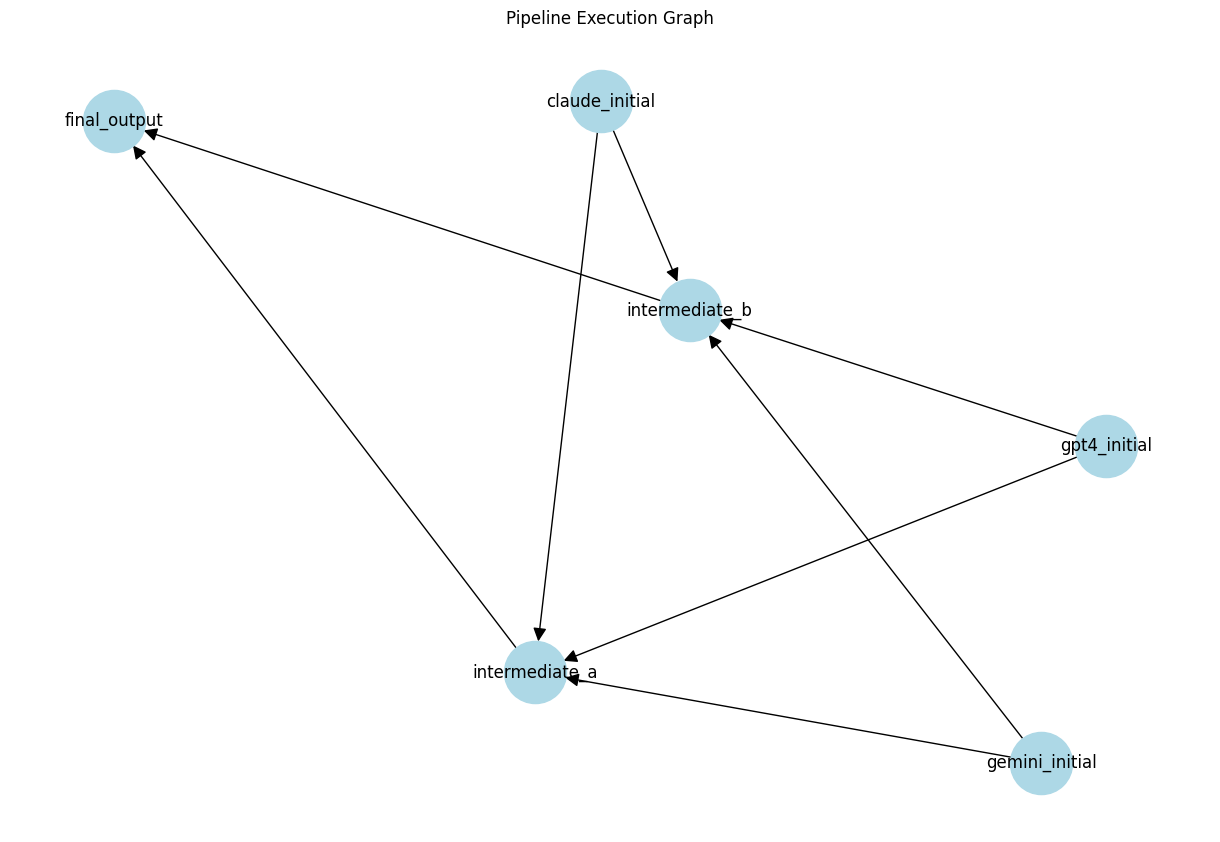

KeyboardInterrupt: 

In [7]:
from typing import Callable, Dict, List, Optional, Any, Set
from dataclasses import dataclass
import inspect
from concurrent.futures import ThreadPoolExecutor, Future, wait, as_completed
from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import threading
from openai import OpenAI
import re
import json
from pathlib import Path
from datetime import datetime
import pandas as pd

# Global locks for thread safety
print_lock = threading.Lock()
results_lock = threading.Lock()

def create_client():
    """Create an OpenAI client with appropriate configuration"""
    return OpenAI(
        api_key="abcd",
        base_url="http://localhost:3060/auto/v1/",
        default_headers={
            "x-proxy-key": "3870443e-1f3e-4e5d-a1fe-4e945828cdc6"
        }
    )

def extract_answer(response: str) -> str:
    """Extract the final answer (A-F) from the model's response."""
    match = re.search(r"Final Answer:\s*([A-F])", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    match = re.search(r"([A-F])\s*$", response, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return "INVALID"

class StepOutput:
    """Represents the output of a pipeline step"""
    def __init__(self, name: str, model: str, system_prompt: str):
        self.name = name
        self.model = model
        self.system_prompt = system_prompt
        self.result: Optional[Dict] = None
        self.dependencies: List['StepOutput'] = []
        self.error: Optional[Exception] = None
    
    def __repr__(self):
        return f"StepOutput(name='{self.name}', model='{self.model}')"

class PipelineContext:
    """Tracks execution context during pipeline tracing and execution"""
    def __init__(self):
        self.tracing = False
        self.steps: Dict[str, StepOutput] = {}
        self.results: Dict[str, Dict] = {}
        self.current_execution: Dict[str, bool] = {}
        self._local = threading.local()
        self.lock = threading.Lock()

# Global context
_context = PipelineContext()

def step(name: str, model: str, system_prompt: str = "You are a helpful assistant."):
    """Creates a pipeline step that can be called with a prompt and dependencies"""
    def step_func(prompt: str, *deps: StepOutput) -> StepOutput:
        # Create step output object
        output = StepOutput(name, model, system_prompt)
        
        # Record dependencies
        output.dependencies = list(deps)
        
        if _context.tracing:
            # Just record the step during tracing
            _context.steps[name] = output
        else:
            # Check if step has already been executed in this run
            with _context.lock:
                if name in _context.current_execution:
                    return _context.steps[name]
                _context.current_execution[name] = True
            
            try:
                # Build context from dependencies
                dep_context = ""
                if deps:
                    dep_context = "\n\nPrevious responses:\n"
                    for dep in deps:
                        if dep.result:
                            dep_context += f"\n{dep.name} ({dep.model}):\n{dep.result['response']}\n"
                            dep_context += f"Answer: {dep.result['extracted_answer']}\n"
                
                # Execute model
                client = create_client()
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": prompt + dep_context}
                    ]
                )
                
                # Process response
                model_response = response.choices[0].message.content
                output.result = {
                    "model": model,
                    "response": model_response,
                    "extracted_answer": extract_answer(model_response)
                }
                
                # Store results
                with _context.lock:
                    _context.results[name] = output.result
                    _context.steps[name] = output
                
            except Exception as e:
                output.error = e
                raise
        
        return output
    
    return step_func

class Pipeline:
    """Manages the tracing and execution of a pipeline function"""
    def __init__(self, func: Callable, max_concurrent: int = 5):
        self.func = func
        self.max_concurrent = max_concurrent
        self.graph = self._trace_function()
    
    def _trace_function(self) -> nx.DiGraph:
        """Trace the function to build dependency graph"""
        _context.tracing = True
        _context.steps.clear()
        
        # Execute function in tracing mode
        self.func("TRACING")
        
        # Build graph from traced steps
        graph = nx.DiGraph()
        
        for step_name, step in _context.steps.items():
            graph.add_node(step_name)
            for dep in step.dependencies:
                graph.add_edge(dep.name, step_name)
        
        # Verify no cycles
        if not nx.is_directed_acyclic_graph(graph):
            raise ValueError("Dependency cycle detected in pipeline")
        
        _context.tracing = False
        return graph
    
    def visualize(self):
        """Visualize the pipeline graph"""
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph)
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            arrowsize=20
        )
        plt.title("Pipeline Execution Graph")
        plt.show()
    
    def execute(self, prompt: str, show_progress: bool = True) -> Dict:
        """Execute the pipeline with the given prompt"""
        _context.results.clear()
        _context.current_execution.clear()
        execution_order = list(nx.topological_sort(self.graph))
        
        if show_progress:
            pbar = tqdm(total=len(execution_order), desc="Executing pipeline")
        
        with ThreadPoolExecutor(max_workers=self.max_concurrent) as executor:
            while execution_order:
                # Find ready steps (all dependencies completed)
                ready_steps = [
                    step for step in execution_order
                    if all(dep in _context.results 
                          for dep in self.graph.predecessors(step))
                ]
                
                if not ready_steps:
                    raise RuntimeError("No steps ready but execution not complete")
                
                # Execute ready steps in parallel
                futures = {}
                for step_name in ready_steps:
                    future = executor.submit(self.func, prompt)
                    futures[future] = step_name
                    execution_order.remove(step_name)
                
                # Wait for completions
                for future in as_completed(futures):
                    step_name = futures[future]
                    try:
                        result = future.result()
                        if show_progress:
                            pbar.update(1)
                    except Exception as e:
                        raise RuntimeError(f"Error in step {step_name}: {str(e)}")
        
        if show_progress:
            pbar.close()
        
        # Execute one final time to get the actual result
        return self.func(prompt)

def evaluate_pipeline(pipeline: Pipeline, json_file: str) -> pd.DataFrame:
    """Evaluate a pipeline on a set of questions"""
    # Load questions
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    questions = data["eval_data"]
    questions = [questions[0]]
    total_questions = len(questions)
    results = []
    
    # Process questions
    pbar = tqdm(total=total_questions, desc="Evaluating pipeline")
    
    for question in questions:
        try:
            # Execute pipeline
            final_result = pipeline.execute(
                question["prompt"],
                show_progress=False
            )
            
            # Get final answer
            model_answer = final_result.result["extracted_answer"]
            correct = model_answer == question["answer"]
            
            # Collect step results
            step_responses = []
            for step_name in nx.topological_sort(pipeline.graph):
                if step_name in _context.results:
                    step_responses.append(_context.results[step_name])
            
            result = {
                "question_id": question["question_id"],
                "correct_answer": question["answer"],
                "model_answer": model_answer,
                "correct": correct,
                "step_responses": step_responses,
                "prompt": question["prompt"]
            }
            
            # Thread-safe printing of detailed results
            with print_lock:
                print(f"\nQuestion {question['question_id']}:")
                for idx, response in enumerate(step_responses, 1):
                    print(f"\nStep {idx} ({response['model']}):")
                    print("-" * 50)
                    print(response['response'])
                    print(f"Answer: {response['extracted_answer']}")
                    print("-" * 50)
                
                print(f"Expected: {question['answer']}")
                print(f"Final Answer: {model_answer}")
                print(f"Correct: {'✓' if correct else '✗'}")
                print("=" * 80)
            
            results.append(result)
            
        except Exception as e:
            print(f"Error processing question {question['question_id']}: {str(e)}")
            results.append({
                "question_id": question["question_id"],
                "correct_answer": question["answer"],
                "model_answer": "ERROR",
                "correct": False,
                "step_responses": [],
                "prompt": question["prompt"]
            })
        
        pbar.update(1)
    
    pbar.close()
    
    # Calculate and display final metrics
    df = pd.DataFrame(results)
    correct_answers = df['correct'].sum()
    accuracy = correct_answers / total_questions
    
    print(f"\nFinal Results:")
    print(f"Total Questions: {total_questions}")
    print(f"Correct Answers: {correct_answers}")
    print(f"Accuracy: {accuracy:.2%}")
    
    return df

def save_results(df: pd.DataFrame, pipeline: Pipeline, output_dir: str = "pipeline_results"):
    """Save evaluation results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_path = Path(output_dir) / timestamp
    base_path.mkdir(parents=True, exist_ok=True)
    
    # Save detailed results
    df.to_csv(base_path / "results.csv", index=False)
    
    # Save pipeline graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(pipeline.graph)
    nx.draw(
        pipeline.graph,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        arrowsize=20
    )
    plt.title("Pipeline Execution Graph")
    plt.savefig(base_path / "pipeline_graph.png")
    plt.close()
    
    # Save individual responses
    responses_dir = base_path / "responses"
    responses_dir.mkdir(exist_ok=True)
    
    for _, row in df.iterrows():
        with open(responses_dir / f"question_{row['question_id']}.txt", 'w') as f:
            f.write(f"Question ID: {row['question_id']}\n")
            f.write(f"Prompt:\n{row['prompt']}\n\n")
            for idx, response in enumerate(row['step_responses'], 1):
                f.write(f"Step {idx} ({response['model']}):\n")
                f.write("-" * 50 + "\n")
                f.write(f"{response['response']}\n")
                f.write(f"Answer: {response['extracted_answer']}\n\n")
            f.write(f"Expected Answer: {row['correct_answer']}\n")
            f.write(f"Final Answer: {row['model_answer']}\n")
            f.write(f"Correct: {row['correct']}\n")

def my_pipeline(prompt: str):
    # Initial models
    gpt4_result = step(
        "gpt4_initial",
        "openai@gpt-4o",
        "You are an expert at solving multiple choice questions."
    )(prompt)
    
    claude_result = step(
        "claude_initial",
        "anthropic@claude-3-5-sonnet-latest",
        "You are an expert at solving multiple choice questions."
    )(prompt)
    
    gemini_result = step(
        "gemini_initial",
        "gemini@gemini-2.0-flash-exp",
        "You are an expert at solving multiple choice questions."
    )(prompt)
    
    # Intermediate analysis
    intermediate_a = step(
        "intermediate_a",
        "openai@gpt-4o",
        "Review the responses and provide your analysis."
    )(prompt, gpt4_result, claude_result, gemini_result)
    
    intermediate_b = step(
        "intermediate_b",
        "anthropic@claude-3-5-sonnet-latest",
        "Review the responses and provide your analysis."
    )(prompt, gpt4_result, claude_result, gemini_result)
    
    # Final aggregation
    final_result = step(
        "final_output",
        "openai@gpt-4o",
        "Analyze all previous responses and provide the final answer."
    )(prompt, intermediate_a, intermediate_b)
    
    return final_result

# Create pipeline
pipeline = Pipeline(my_pipeline)

# Visualize the pipeline
pipeline.visualize()

# Run evaluation
results_df = evaluate_pipeline(pipeline, "simple_bench_public.json")

# Save results
save_results(results_df, pipeline)
